<a href="https://colab.research.google.com/github/MySureStart/spring_2023_vail-Mennatullah-Elsahy/blob/main/Day_14/Computer_Vision_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

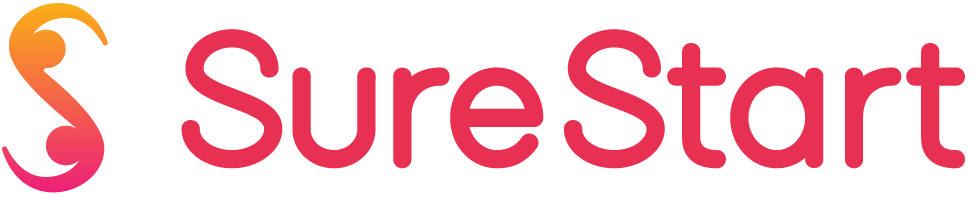

#Day 14 Objectives:
* Introduction to Computer Vision (CV) to understand how machines “see” the visual world. 
* Learn how machines can “read” your emotions by looking at your face.

#Talking about style transfer

Neural style transfer is an optimization technique used to take three images, a content image, a style reference image (such as an artwork by a famous painter), and the input image you want to style — and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.

Style transfer consists in generating an image with the same "content" as a base image, but with the "style" of a different picture (typically artistic). This is achieved through the optimization of a loss function that has 3 components: "style loss", "content loss", and "total variation loss":

* The total variation loss imposes local spatial continuity between the pixels of the combination image, giving it visual coherence.

* The style loss is where the deep learning keeps in --that one is defined using a deep convolutional neural network. Precisely, it consists in a sum of L2 distances between the Gram matrices of the representations of the base image and the style reference image, extracted from different layers of a convnet (trained on ImageNet). The general idea is to capture color/texture information at different spatial scales (fairly large scales --defined by the depth of the layer considered).

* The content loss is a L2 distance between the features of the base image (extracted from a deep layer) and the features of the combination image, keeping the generated image close enough to the original one.

## Question 1
How are GANs and Style transfer connected?

### Answer 1


GANs and Style transfer are both techniques used in computer vision and deep learning for image synthesis. GANs are used for image generation by learning to generate new images that resemble a training set of images, while Style transfer generates an image with the style of a reference image while preserving the content of a different image. Recent research has explored the use of GANs for style transfer, either by using a GAN to generate the stylized image directly or by using a GAN to learn a style transfer network for fast style transfer on new images.





In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19

base_image_path = tf.keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = tf.keras.utils.get_file(
    "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = tf.keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

935806/935806 [==============================] - 1s 1us/step


Let's take a look at our base (content) image and our style reference image


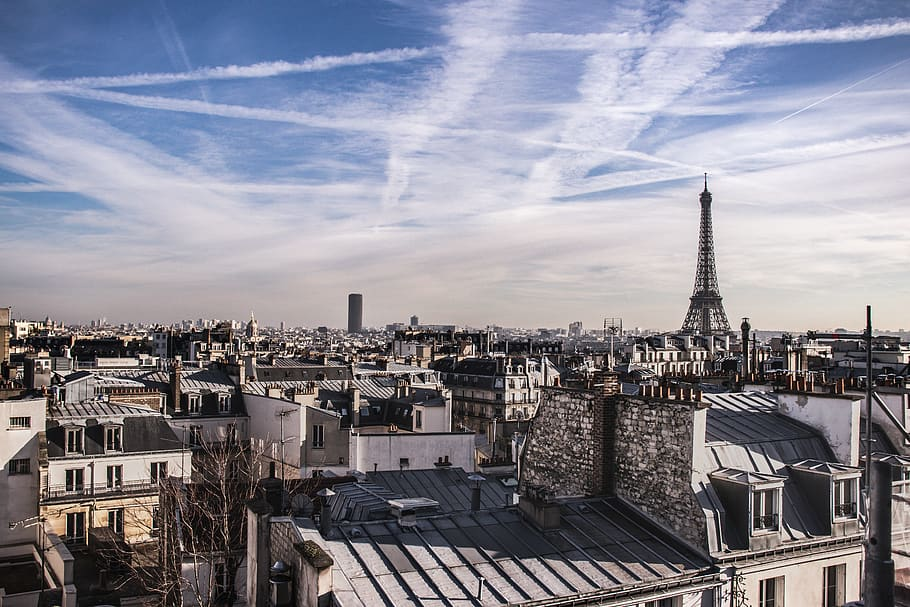

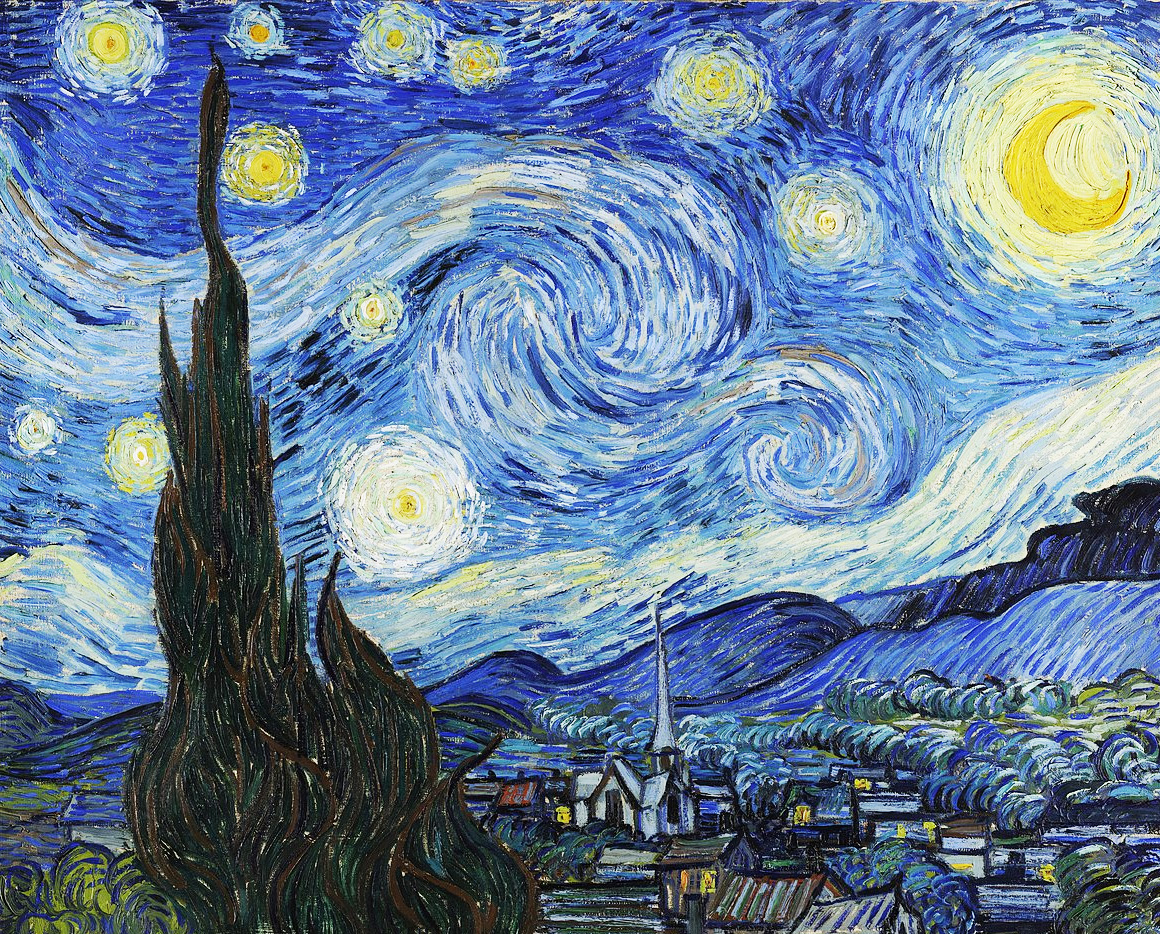

In [2]:
from IPython.display import Image, display

display(Image(base_image_path, width = 1000, height = 600))
display(Image(style_reference_image_path, width = 1000, height = 600))


# Image preprocessing/deprocessing utilities
Images need to be passed in through an tensor to process through our Deep Learning model.

But need to be in RBG numpy array to be visualized as a valid image.

In [3]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Question 2

Why do we not normalize the images in this case of style transfer?

### Answer 2

Normalization of images is not typically done in the case of style transfer because it can alter the style of the image being transferred. The aim of style transfer is to generate an image with the same content as the base image but with the style of a reference image. The style information is extracted from the Gram matrices of the features of the reference image. If normalization is applied to the input images, it can change their pixel values, which can result in changes in the Gram matrices and thus alter the style information extracted from them. Therefore, it is typically recommended to avoid normalization of input images in style transfer, in order to preserve the style information and generate an output image with the desired artistic style.

# Explaining the various Losses

* Content Loss:

It helps to establish similarities between the content image and the generated image. It is intuitive that higher layers of the model focus more on the features present in the image i.e. overall content of the image.

Content loss is calculated by Euclidean distance between the respective intermediate higher-level feature representation of input image (x) and content image (p) at layer l.
$$L^l_{content}(p,x)=\sum_{i,j}(F_{i,j}^l(x)-P_{i,j}^l(x))$$

We perform backpropagation in the usual way such that we minimize this content loss. We thus change the initial image until it generates a similar response in a certain layer (defined in content_layer) as the original content image.
This can be implemented quite simply.

* Style loss: 

Style loss is conceptually different from Content loss. We cannot just compare the intermediate features of the two images and get the style loss. That's why we introduce a new term called Gram matrices.

Gram matrix is a way to interpret style information in an image as it shows the overall distribution of features in a given layer. It is measured as the amount of correlation present between features maps in a given layer.

Style loss is calculated by the distance between the gram matrices (or, in other terms, style representation) of the generated image and the style reference image.

The contribution of each layer in the style information is calculated by the below formula:

$$E_l = \frac{1}{4N^2_lM^2_l}\sum_{i,j}(G^l_{i,j}-A^l_{i,j})^2$$
Thus, the total style loss across each layer is expressed as:
$$L_{style}(a,x)=\sum_{l\in L}w_l E_l$$

* Total Variational loss:

Total variation loss is the sum of the absolute differences for neighboring pixel-values in the input images. This measures how much noise is in the images.

Sometimes, the learned synthesized image has a lot of high-frequency noise, i.e., particularly bright or dark pixels. One common noise reduction method is total variation denoising. Denote by  xi,j  the pixel value at coordinate  (i,j).
$$\sum_{i,j}|x_{i,j}−x_{i+1,j}|+|x_{i,j}−x_{i,j+1}|$$

More can be read at: https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee

https://www.datacamp.com/community/tutorials/implementing-neural-style-transfer-using-tensorflow


#Compute the style transfer loss
First, we need to define 4 utility functions:

* gram_matrix (used to compute the style loss)
* The style_loss function, which keeps the generated image close to the local textures of the style reference image
* The content_loss function, which keeps the high-level representation of the generated image close to that of the base image
* The total_variation_loss function, a regularization loss which keeps the generated image locally-coherent

In [4]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# Loading a model which can determine featuers in a model
Let's create a feature extraction model that retrieves the intermediate activations of VGG19 (as a dict, by name). We use a pretrained model for its ability to determine the general patters available in imagenet dataset images.

In [5]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 4s 0us/step


## Question 3
We have used the VGG19 model here. Would other models suffice? 

Why do we use a pretrained model rather than a custom model?

### Answer 3

While VGG19 is commonly used for style transfer, other models can also be used. Pre-trained models are preferred over custom models due to their ability to extract feature maps from the input image without requiring additional training on a custom dataset, saving time and computational resources. Additionally, pre-trained models like VGG19 have been optimized for style transfer, making them a popular and effective choice.


# Defining the style transfer model and computing the loss
In order to extract the content features and style features of the image, we can select the output of certain layers in the VGG network. Generally speaking, the closer to the input layer, the easier to extract details of the image, and vice versa, the easier to extract the global information of the image. In order to avoid excessively retaining the details of the content image in the synthesized image, we choose a VGG layer that is closer to the output as the content layer to output the content features of the image. We also select the output of different VGG layers for extracting local and global style features. These layers are also called style layers.The VGG network uses 5 convolutional blocks. In the experiment, we choose the last convolutional layer of the fourth convolutional block as the content layer, and the first convolutional layer of each convolutional block as the style layer. 

Finally, here's the code that computes the style transfer loss.



In [6]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

## Question 4
Why do we use different sequential models to compute style and content layers for the VGG19 model?

### Answer 4

Different sequential models are used to compute style and content layers in the context of style transfer with VGG19 because they serve different purposes. The style layers need to capture information about the style image's color and texture, while the content layers need to capture information about the content image's structure and spatial layout. By using different sequential models for style and content layers, we can extract the necessary information from the style and content images to create a stylized output that combines the content of the content image with the style of the style image.

Add a tf.function decorator to loss & gradient computation
To compile it, and thus make it fast.

In [7]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

The training loop
Repeatedly run vanilla gradient descent steps to minimize the loss, and save the resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.



In [8]:
optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        tf.keras.preprocessing.image.save_img(fname, img)


Iteration 100: loss=11018.28
Iteration 200: loss=8513.97
Iteration 300: loss=7571.40
Iteration 400: loss=7063.66
Iteration 500: loss=6735.48
Iteration 600: loss=6501.03
Iteration 700: loss=6322.66
Iteration 800: loss=6181.00
Iteration 900: loss=6065.12
Iteration 1000: loss=5967.66
Iteration 1100: loss=5884.61
Iteration 1200: loss=5812.89
Iteration 1300: loss=5750.41
Iteration 1400: loss=5695.76
Iteration 1500: loss=5647.48
Iteration 1600: loss=5604.46
Iteration 1700: loss=5565.81
Iteration 1800: loss=5531.00
Iteration 1900: loss=5499.47
Iteration 2000: loss=5470.81
Iteration 2100: loss=5444.67
Iteration 2200: loss=5420.68
Iteration 2300: loss=5398.69
Iteration 2400: loss=5378.44
Iteration 2500: loss=5359.73
Iteration 2600: loss=5342.44
Iteration 2700: loss=5326.43
Iteration 2800: loss=5311.59
Iteration 2900: loss=5297.80
Iteration 3000: loss=5284.97
Iteration 3100: loss=5272.97
Iteration 3200: loss=5261.75
Iteration 3300: loss=5251.25
Iteration 3400: loss=5241.43
Iteration 3500: loss=5

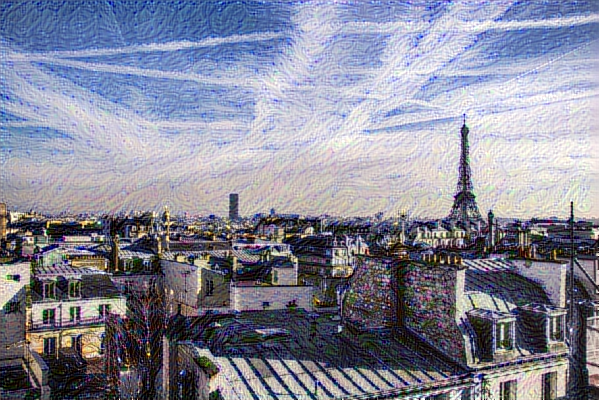

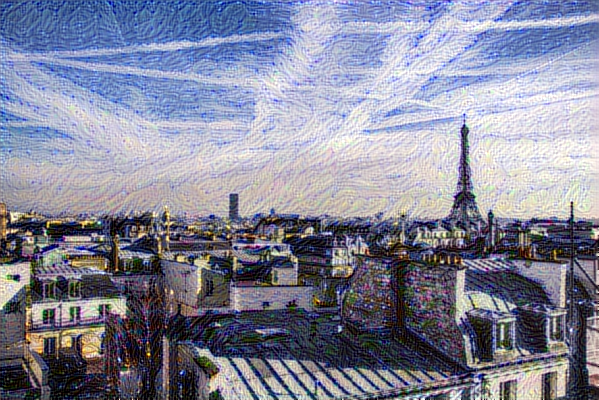

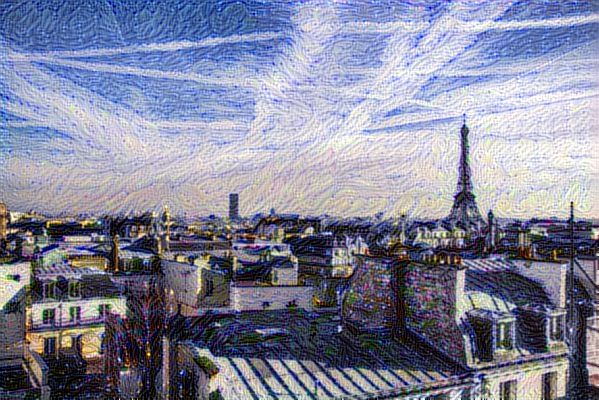

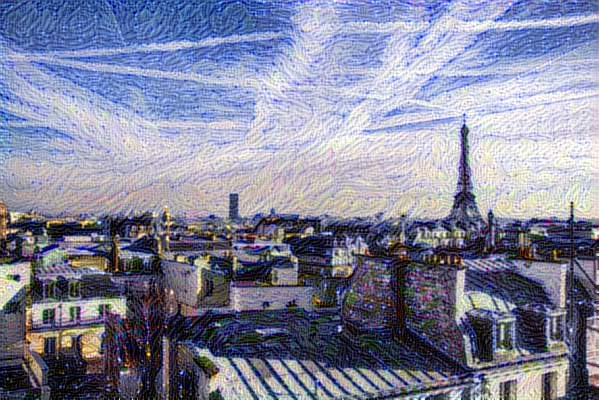

In [9]:
for i in range(iterations//100):
  display(Image(result_prefix + "_at_iteration_"+str((i+1)*100)+".png"))


## Bonus Question 
Use a different state of the art model to perform style transfer.

The Adaptive Instance Normalization Style Transfer Network (AdaIN) is a state-of-the-art model for style transfer. It is based on a modified version of the U-Net architecture and uses instance normalization to normalize the content and style features separately before combining them using a scaling and shifting operation learned during training. AdaIN is known to produce stylized images with more realistic textures and finer details than VGG19, but it may require more computational resources and longer training times. To perform style transfer using AdaIN, we would need to use a pre-trained AdaIN model and modify the code to load the model, input images, and apply the stylization process.

Source: 

https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/2.0-GAN-fashion-mnist.ipynb

https://www.bpesquet.fr/mlhandbook/algorithms/neural_style_transfer.html

https://keras.io/examples/generative/neural_style_transfer/